In [1]:
import re, os
from datetime import datetime
import shutil
import pickle
from collections import OrderedDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.display import display

ROOT_FOLDER = "/mnt/hgfs/projlogs/SFW/sops1/SOPS/Performance Test - Performance_Test1"
ROOT_FOLDER = "/mnt/hgfs/projlogs/SFW/hq1/Performance Test - Performance_Test1"
# MILL, POND, OPP1, OPP2, FOX
# SOPS, HQ1, BAYVIEW, FIELD1
# Bristol720, JouleHouse, Birchwood, Leicester
# fox, mill, pond, opp1, opp2
ROOT_FOLDER = "/mnt/hgfs/projlogs/Integral/Maximo_13_mar/"
MSG_SHORT_LEN = 20 #characters

In [2]:
# pd.set_option('display.mpl_style', 'default')
pd.set_option('plotting.matplotlib.register_converters', 'default')
%matplotlib inline
plt.style.use('ggplot')
sns.set_color_codes("pastel")

In [3]:
class TestError():

    def __init__(self, timestamp, userid, cycleid, uj, stepid, errortype, message, test_folder):
        self.time = pd.to_datetime(timestamp, infer_datetime_format=True) 
        self.userid = userid
        self.cycleid = cycleid
        self.stepid = stepid
        self.errortype = errortype
        self.message = message
        self.test_folder = test_folder
        self.uj = uj
        
        self.cause = ''
        self.cause_message = ''
        
        if errortype == 'Success Validation Failure':
            sv = re.search(r'failed sub validations: (.+?)\) for step ".+?" was not found in the response. The response received has been written to "(.+?)"', message)
            self.validation = sv.group(1)
            self.file = sv.group(2)
            # name_parts = self.file.split('__')
            # self.uj = name_parts[0]
        else:
            self.validation = None
            self.file = None

        if errortype == 'Response DD Extraction Failure':
            ddisrc = re.search(r'Error reading value for response DD item (.+?) used in step (.+?)', message)
            self.dditem = ddisrc.group(1)
            # !!! the line below currently gives wrong value due to BUG in the ST logs.
            # self.ddi_source = ddisrc.group(2)
        else:
            self.dditem = None
    
    def show(self, shorten=True):
        if shorten:
            message = self.cause_message[:MSG_SHORT_LEN] + (len(self.cause_message)>MSG_SHORT_LEN)*'...'
        if self.dditem:
            message = self.dditem
        return OrderedDict([('time', self.time),
                ('user', self.userid),
#                 ('total errors', 0),
                ('uj', self.uj),
                ('step', self.stepid),
                ('cycle', self.cycleid),
                ('error type', self.errortype),
                ('error cause', self.cause),
                ('cause message/ddi', self.cause_message),
               ])
    
    def set_snapshot_details(self):
        pass
        
    def _read_error_file(self):
        if self.errortype == 'Success Validation Failure':
            try:
                # for QR, log files are directly in the log folder for the run
                with open(os.path.join(self.test_folder, self.file), 'rt') as f:
                    html = f.read()
            except FileNotFoundError:
                # for non-QR, log files are in subfolders named after virtual user ids
                with open(os.path.join(self.test_folder, 'user'+self.userid , self.file), 'rt') as f:
                    html = f.read()

        return html
    
    def _set_cause(self, cause, message):
        self.cause = cause
        self.cause_message = message
        
    def determine_casuse(self):
        if self.errortype == 'Success Validation Failure':
            html = self._read_error_file()
            if html.count('<label for="username">User Name:</label>')>0:
                self._set_cause('logged off', '')
                return None

            kick_match = re.search(r'redirect><\!\[CDATA\[https*://.+?/maximo/webclient/login/logout.jsp.*?\]\]></redirect>', html)
            if kick_match is not None:
                self._set_cause('Maximo forcefully signed out the user', '')
                return None

            if html.count('title="Please wait...">Please wait...</label>')>0:
                self._set_cause('Long Op', '')
                return None
            
            if html.count("addLongOpTimeout('dolongopquerycheck()',")>0:
                self._set_cause('Long Op', '')
                return None

            if html.count('MessageWarning.png')>0:
                msg = html[html.find('MessageWarning.png'):]
                msg = '<' + msg[:msg.find('</table>')]
                msg = re.sub(r'<[^>]*?>', '', msg)
                msg = msg.replace('\n','').strip()
                self._set_cause('Warning Message', msg)
                return None

            if html.count('st_MessageQuestion.png')>0:
                msg = html[html.find('st_MessageQuestion.png'):]
                msg = '<' + msg[:msg.find('</table>')]
                msg = re.sub(r'<[^>]*?>', '', msg)
                msg = msg.replace('\n','').strip()
                self._set_cause('Question Message', msg)
                return None
            
            if html.count('st_MessageCritical.png')>0:
                msg = html[html.find('st_MessageCritical.png'):]
                msg = '<' + msg[:msg.find('</table>')]
                msg = msg[:msg.find('</component>')]                
                msg = re.sub(r'<[^>]*?>', '', msg)
                msg = msg.replace('\n','').strip()
                self._set_cause('Critical Message', msg)
                return None

            if html.count('>0 - 0 of 0')>0:
                self._set_cause('operation resulted in a table with zero rows', 'searchterm: ' + self.validation)
                return None

            break_index = html.find('---------------Response-----------------')
            html_request_only = html[:break_index]
            html_response_only = html[break_index + 40:]
            if html_response_only.count(self.validation)>0:
                self._set_cause('validation bug', 'searchterm: ' + self.validation)
                return None

            ###  --- COB specific errors ---
            if  html_response_only.count('"id":"0_APPRSS_OPTION","text":"APPRSS"') and not html_response_only.count('Approved'):
                self._set_cause('missing "Approved" option', '')
                return None

            if html_request_only.count('targetId%22%3A%22mx387') and html_response_only.count('title="1 - 2 of 2">1 - 2'):
                self._set_cause('dynamic response', 'missing reference of WO field, thus cant validate')
                return None

            if html_request_only.count('<command>ISWM-RECORDFAILUREREPORT</command>'):
                self._set_cause('response lacks confirmation of recordid', 'response lacks confirmation of recordid')
                return None   
            ### --- ==================== ---
            
            ###  --- Integral specific errors ---
            if  html_response_only.count('The PPM & Work Order Billing Process has now been initiated.') and \
                                                    not html_response_only.count('Record has been saved.'):
                self._set_cause('new Wrokflow response',
                    'received "The PPM & Work Order Billing Process has now been initiated." instead of "Record has been saved."')
                return None
            
            if  html_response_only.count('>Do nothing</label>') and html_response_only.count('>Cancel the bill</label>'):
                self._set_cause('new Wrokflow response', 'received radio buttons "Do nothing" and "Cancel the bill"')
                return None
            ### --- ==================== ---
            
            self._set_cause('unknown validation fail', html_response_only)
            self.html = html
        else:
            self._set_cause(self.errortype, '')


In [4]:
class Loop():
    
    def __init__(self, lead_error, lenght):
        # the start & end index, should refer to cycle index, not error index
        self.lead_error = lead_error
        self.start = int(lead_error.cycleid)
        self.end = self.start + lenght
        # the +1 is needed because both the starter and the final cycles are part of the loop
        # it shouldn't be passed in the constructor in order to properly calculate the end cycle id
        self.lenght = lenght + 1
        
    def show(self):
        return OrderedDict([('loop start', self.start), ('loop length', self.lenght),])
    
    def __repr__(self):
        return str(self.start) + '-' + str(self.end)

In [5]:
class VirtualUser():
    
    def __init__(self, userid, start_time, uj, errors=[], loops=[], max_loop=None):
        self.userid = userid
        self.start_time = start_time
        self.uj = uj
        self.errors = errors
        self.loops = loops
        self.max_loop = max_loop
        
    # If I can user.errors.append(err) , why create a method?
    def append_error(self, error):
        self.errors.append(error)

    def process_errors(self):
        self.error_count = len(self.errors)
        
        consecutive_count = 0
        consecutiveness = ''
        max_consecutive = -1
        max_loop = -1
        # looping over errors in reverse, thus init with values of the last error in the list
        prior_error = self.errors[-1]
        for error in reversed(self.errors):
            error.determine_casuse()

            # the 1st condition needs <= instead of == because there could be multiple errors per cycleid
            # the 2nd condoition is to avoid counting the initial record as a consecutive term
            if int(prior_error.cycleid) - int(error.cycleid) <= 1 and error != self.errors[-1]:
                consecutive_count += 1
            else:
                if consecutive_count > 0:
                    new_loop = Loop(prior_error, consecutive_count)
                    self.loops.append(new_loop)
                    consecutiveness = ';' + str(new_loop) + consecutiveness

                    # update max_loop
                    if consecutive_count > max_consecutive:
                        max_consecutive = consecutive_count
                        self.max_loop = new_loop

                consecutive_count = 0
                
            prior_error = error
        
        # check if the for-ending error was completing an error-loop
        if consecutive_count > 0:
            new_loop = Loop(prior_error, consecutive_count)
            self.loops.append(new_loop)
            consecutiveness = ';' + str(new_loop) + consecutiveness

            # update max_loop
            if consecutive_count > max_consecutive:
                max_consecutive = consecutive_count
                self.max_loop = new_loop
        
        self._process_cause_stats()
        
        return consecutiveness[1:]
    
    def _process_cause_stats(self):
        causes = {}
        for e in self.errors:
            if e.cause in causes.keys():
                causes[e.cause] += 1
            else:
                causes[e.cause] = 1

        self.causes = causes
        
    def lead_error_info(self, shorten=True):
        # return info on the "lead" error of the longest error-loop
        #   or the first error for the user
        
        if self.max_loop:
            lead_error_info = self.max_loop.lead_error.show(shorten=shorten)
            max_loop_info = self.max_loop.show()
        else:
            lead_error_info = self.errors[0].show(shorten=shorten)
            max_loop_info = OrderedDict([('loop start', ''), ('loop length', '')])
            
        def surgery(ordered_dict, index, insertion):
            return OrderedDict(list(ordered_dict.items())[:index] + 
                               list(insertion.items()) + 
                               list(ordered_dict.items())[index:])
        
        lead_error_info = surgery(lead_error_info, 2, {'total errors': user.error_count})
        lead_error_info = surgery(lead_error_info, -2, max_loop_info)
            
        return lead_error_info
    
    def get_errors(self, shorten=True):
        result = pd.DataFrame([ z.show(shorten=shorten) for z in self.errors ])
        result.index = pd.to_datetime(result.time, errors='coerce')
        result.drop(columns=['time'])
        return result

the graph functionality should not be tied in the classes; plotting should decouple from DF resampling

In [6]:
def groupby_resample(udf, feature, freq='H'):
    tmpdf = pd.DataFrame()
    tmpdf[feature] = udf[feature]
    ndf = tmpdf.groupby(feature).resample(freq).count().unstack(feature)
    return ndf
    # ndf.plot.bar(stacked=True)

In [7]:
def timeslice(df, start=None, end=None):
    # 
    if start and isinstance(start, str):
        start = pd.to_datetime(start, errors='coerce')
    if end and isinstance(end, str):
        end = pd.to_datetime(end, errors='coerce')
    if start and end:
        ndf = df[start:end]
    elif start and not end:
        ndf = df[start:]
    elif end and not start:
        ndf = df[:end]
    else:
        ndf = df[:]
    return ndf

In [8]:
def bar_categorical(udf, feature, freq='H', figsize=(12,8), title=None):
    tmpdf = pd.DataFrame()
    tmpdf[feature] = udf[feature]
    ndf = tmpdf.groupby(feature).resample(freq).count().unstack(feature)
    ndf.plot.bar(stacked=True, figsize=figsize)
    if title:
        plt.title(title);

# Load pickles

Determine the number of relevant injector folders.

In [9]:
test_folder = ROOT_FOLDER

## Considered running simultaneous analisys of different injectors:
##    it will not work, because user ids are repeated i.e user 0006 on INJ1 will be assigned to UJ1,
##    while user 0006 on INJ2 will have different UJ, and different errors, and etc.

folders = [ f for f in os.listdir(test_folder) if os.path.isdir(os.path.join(test_folder,f)) ]
print('at', test_folder, ', found', len(folders), 'injector folders: ', folders)

at /mnt/hgfs/projlogs/Integral/Maximo_13_mar/ , found 4 injector folders:  ['Birchwood', 'Bristol720', 'JouleHouse', 'Leicester']


In case of multiple log files, merge them and work with the merged file.

In [10]:
if len(folders)>1:
    print('multiple injectors found - loading pickeles:')
    injectors = {}
    for inj_folder in folders:
        injectors[inj_folder] = pickle.load(open(os.path.join(test_folder, inj_folder, 'with_loops.pickle'), 'rb'))
        print('injector', inj_folder, 'reports', len(injectors[inj_folder]), 'erroring users')
else:
    print('one or no folders found - exiting')
    exit(1)

multiple injectors found - loading pickeles:
injector Birchwood reports 1 erroring users
injector Bristol720 reports 14 erroring users
injector JouleHouse reports 5 erroring users
injector Leicester reports 2 erroring users


### Overall injector stats

In [11]:
# vusers = pickle.load(open(os.path.join(test_folder, 'with_loops.pickle'), 'rb'))

In [12]:
causes = {}
causes_keys = []
accu = []
for inj in folders:
    sorted_keys = sorted(injectors[inj].keys())
    for userid in sorted_keys:
        user = injectors[inj][userid]
        errors_values = list(user.lead_error_info(shorten=False).values())
        all_user_errors = user.get_errors(shorten=False)
        unknowns = all_user_errors.loc[all_user_errors['error cause'] == 'unknown validation fail']
        if len(unknowns):
            print('   >>>', inj, userid)
            display(unknowns)
        accu.append([inj] + errors_values)
        for val in errors_values:
            try:
                print(val[:250], end=',')
            except TypeError:
                print(val, end=',')
        print()
        if causes_keys == []:
            causes_keys = list(user.lead_error_info(shorten=False))

        # summation of values of corresponding key over list of dicts
        for key in user.causes.keys():
            causes[key]=causes.setdefault(key, 0) + user.causes[key]

data = pd.DataFrame(accu, columns=['inj'] + causes_keys)
data

2018-03-13 20:13:53,0005,43,Billing,Select All Records 1,15,Success Validation Failure,15,37,operation resulted in a table with zero rows,searchterm: <div id="mbff42c79_tdrow_\[C:0\]_tbselrow-gr\[R:\d+?\]".+?checked="checked",
   >>> Bristol720 0022


,time,user,uj,step,cycle,error type,error cause,cause message/ddi
time,,,,,,,,
2018-03-13 19:56:49,2018-03-13 19:56:49,0022,,Homepage,1,Success Validation Failure,unknown validation fail,"\n<!DOCTYPE html>\n<html lang=""en"">\n\t<head>\..."


2018-03-13 19:56:08,0022,2,, (3),0,Connection Error,0,2,Connection Error,,
   >>> Bristol720 0025


,time,user,uj,step,cycle,error type,error cause,cause message/ddi
time,,,,,,,,
2018-03-13 19:58:12,2018-03-13 19:58:12,0025,,Homepage,1,Success Validation Failure,unknown validation fail,"\n<!DOCTYPE html>\n<html lang=""en"">\n\t<head>\..."


2018-03-13 19:57:46,0025,2,, (5),0,Connection Error,0,2,Connection Error,,
   >>> Bristol720 0028


,time,user,uj,step,cycle,error type,error cause,cause message/ddi
time,,,,,,,,
2018-03-13 19:59:53,2018-03-13 19:59:53,0028,,Homepage,1,Success Validation Failure,unknown validation fail,"\n<!DOCTYPE html>\n<html lang=""en"">\n\t<head>\..."


2018-03-13 19:59:25,0028,2,, (5),0,Connection Error,0,2,Connection Error,,
2018-03-13 20:07:57,0044,1,,Homepage,0,Connection Error,,,Connection Error,,
   >>> Bristol720 0062


,time,user,uj,step,cycle,error type,error cause,cause message/ddi
time,,,,,,,,
2018-03-13 20:19:32,2018-03-13 20:19:32,0062,,Homepage,1,Success Validation Failure,unknown validation fail,"\n<!DOCTYPE html>\n<html lang=""en"">\n\t<head>\..."


2018-03-13 20:18:10,0062,2,, (4),0,Connection Error,0,2,Connection Error,,
   >>> Bristol720 0067


,time,user,uj,step,cycle,error type,error cause,cause message/ddi
time,,,,,,,,
2018-03-13 20:22:12,2018-03-13 20:22:12,0067,,Homepage,1,Success Validation Failure,unknown validation fail,"\n<!DOCTYPE html>\n<html lang=""en"">\n\t<head>\..."


2018-03-13 20:20:55,0067,2,, (3),0,Connection Error,0,2,Connection Error,,
   >>> Bristol720 0078


,time,user,uj,step,cycle,error type,error cause,cause message/ddi
time,,,,,,,,
2018-03-13 20:27:45,2018-03-13 20:27:45,0078,,Homepage,1,Success Validation Failure,unknown validation fail,"\n<!DOCTYPE html>\n<html lang=""en"">\n\t<head>\..."


2018-03-13 20:26:56,0078,2,, (2),0,Connection Error,0,2,Connection Error,,
2018-03-13 20:07:37,0080,62,Billing,Route Workflow 1,15,Success Validation Failure,15,55,new Wrokflow response,received "The PPM & Work Order Billing Process has now been initiated." instead of "Record has been saved.",
2018-03-13 20:20:01,0081,44,Billing,Select All Records 1,17,Success Validation Failure,17,43,operation resulted in a table with zero rows,searchterm: <div id="mbff42c79_tdrow_\[C:0\]_tbselrow-gr\[R:\d+?\]".+?checked="checked",
2018-03-13 20:40:03,0082,28,Billing,Select All Records 1,26,Success Validation Failure,26,23,operation resulted in a table with zero rows,searchterm: <div id="mbff42c79_tdrow_\[C:0\]_tbselrow-gr\[R:\d+?\]".+?checked="checked",
2018-03-13 19:48:53,0083,40,Billing,Route Workflow 1,0,Success Validation Failure,0,40,new Wrokflow response,received radio buttons "Do nothing" and "Cancel the bill",
2018-03-13 21:00:04,0086,3,Billing,Select All Records 1,29,Success Validation Failu

,time,user,uj,step,cycle,error type,error cause,cause message/ddi
time,,,,,,,,
2018-03-13 19:54:20,2018-03-13 19:54:20,0008,,Homepage,1,Success Validation Failure,unknown validation fail,"\n<!DOCTYPE html>\n<html lang=""en"">\n\t<head>\..."


2018-03-13 19:54:07,0008,2,, (2),0,Connection Error,0,2,Connection Error,,
   >>> JouleHouse 0009


,time,user,uj,step,cycle,error type,error cause,cause message/ddi
time,,,,,,,,
2018-03-13 19:55:40,2018-03-13 19:55:40,0009,,Homepage,1,Success Validation Failure,unknown validation fail,"\n<!DOCTYPE html>\n<html lang=""en"">\n\t<head>\..."


2018-03-13 19:55:28,0009,2,, (2),0,Connection Error,0,2,Connection Error,,
2018-03-13 20:12:16,0010,56,Billing,Select All Records 1,18,Success Validation Failure,18,48,operation resulted in a table with zero rows,searchterm: <div id="mbff42c79_tdrow_\[C:0\]_tbselrow-gr\[R:\d+?\]".+?checked="checked",
2018-03-13 20:19:47,0011,42,Billing,Select All Records 1,15,Success Validation Failure,15,41,operation resulted in a table with zero rows,searchterm: <div id="mbff42c79_tdrow_\[C:0\]_tbselrow-gr\[R:\d+?\]".+?checked="checked",
2018-03-13 20:38:37,0012,20,Billing,Select All Records 1,16,Success Validation Failure,16,16,operation resulted in a table with zero rows,searchterm: <div id="mbff42c79_tdrow_\[C:0\]_tbselrow-gr\[R:\d+?\]".+?checked="checked",
   >>> Leicester 0001


,time,user,uj,step,cycle,error type,error cause,cause message/ddi
time,,,,,,,,
2018-03-13 19:47:24,2018-03-13 19:47:24,0001,,Homepage,1,Success Validation Failure,unknown validation fail,"\n<!DOCTYPE html>\n<html lang=""en"">\n\t<head>\..."


2018-03-13 19:47:13,0001,2,, (4),0,Connection Error,0,2,Connection Error,,
2018-03-13 20:11:00,0005,57,Billing,Select SR OK,16,Success Validation Failure,16,52,Critical Message,BMXAQ0426E - A new bill for the customer agreement cannot be created at this time. Either bill lines are being copied to a bill batch or a previous copy failed and has not been reset. The copy process must be complete before a new bill can be created,


,inj,time,user,total errors,uj,step,cycle,error type,loop start,loop length,error cause,cause message/ddi
0,Birchwood,2018-03-13 20:13:53,0005,43,Billing,Select All Records 1,15,Success Validation Failure,15,37,operation resulted in a table with zero rows,"searchterm: <div id=""mbff42c79_tdrow_\[C:0\]_t..."
1,Bristol720,2018-03-13 19:56:08,0022,2,,(3),0,Connection Error,0,2,Connection Error,
2,Bristol720,2018-03-13 19:57:46,0025,2,,(5),0,Connection Error,0,2,Connection Error,
3,Bristol720,2018-03-13 19:59:25,0028,2,,(5),0,Connection Error,0,2,Connection Error,
4,Bristol720,2018-03-13 20:07:57,0044,1,,Homepage,0,Connection Error,,,Connection Error,
5,Bristol720,2018-03-13 20:18:10,0062,2,,(4),0,Connection Error,0,2,Connection Error,
6,Bristol720,2018-03-13 20:20:55,0067,2,,(3),0,Connection Error,0,2,Connection Error,
7,Bristol720,2018-03-13 20:26:56,0078,2,,(2),0,Connection Error,0,2,Connection Error,
8,Bristol720,2018-03-13 20:07:37,0080,62,Billing,Route Workflow 1,15,Success Validation Failure,15,55,new Wrokflow response,"received ""The PPM & Work Order Billing Process..."
9,Bristol720,2018-03-13 20:20:01,0081,44,Billing,Select All Records 1,17,Success Validation Failure,17,43,operation resulted in a table with zero rows,"searchterm: <div id=""mbff42c79_tdrow_\[C:0\]_t..."


Info on the "lead" errors for the longest error-loop or, if no error-loop, the first error for the user:

In [13]:
cat = list(causes.items())
stats = [ z[1] for z in cat ]
types = [ z[0] for z in cat ]
# cdf = pd.DataFrame(stats, index=types, columns=['cause type'])
cdft = pd.DataFrame([stats], index=['count'], columns=types)
# cdf.plot.bar(figsize=(12,8));
# the_table = plt.table(cellText=[stats], loc='top') #rowLabels= ['cause type'],
# the_table.set_fontsize(14)

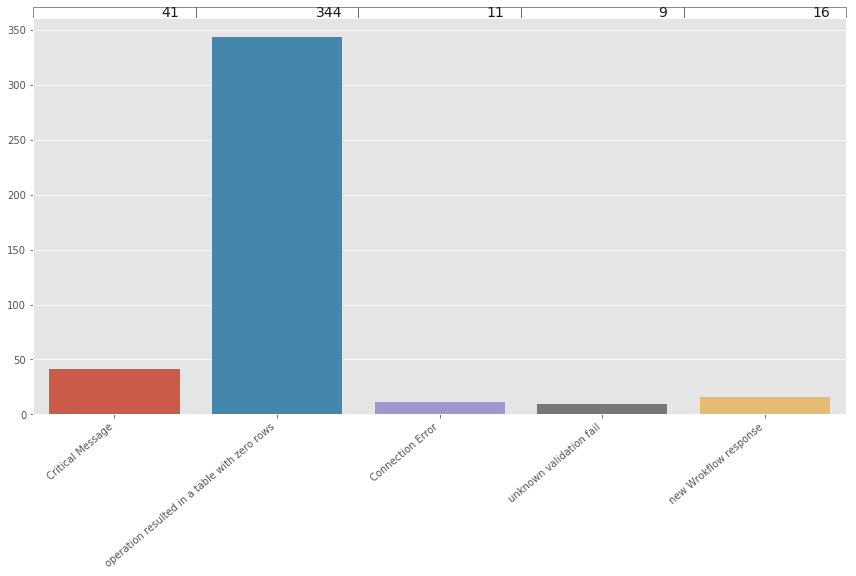

In [14]:
f, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=cdft);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
the_table = plt.table(cellText=[stats], loc='top') #rowLabels= ['cause type'],
the_table.set_fontsize(14)
plt.tight_layout()
plt.show();

# Analysis of individual virtual users

In [15]:
FAIL HERE

SyntaxError: invalid syntax (<ipython-input-15-f2aac8727edc>, line 1)

In [ ]:
%%javascript
IPython.notebook.kernel.execute("URL = '" + window.location + "'");

In [ ]:
uid = URL.split('?')[1].split('=')[1]
errs9 = vusers[uid].get_errors()

In [ ]:
uid='0005'
errs9 = vusers[uid].get_errors()

In [ ]:
# shorten the cause message
errs9['cause message/ddi'] = errs9['cause message/ddi'].apply(lambda x: x[:50])
bar_categorical(errs9, 'error type', 'T', figsize=(15,9), title=uid + '_' + vusers[uid].uj);
bar_categorical(errs9, 'cause message/ddi', 'T', figsize=(15,9));
bar_categorical(errs9, ['step'], 'T', figsize=(15,9))

In [ ]:
pd.options.display.max_rows = 9999
display(errs9)

-------------------------------------

In [ ]:
sdf = timeslice(errs9, datetime(2018, 1, 29, 9, 41, 26), datetime(2018, 1, 29, 9, 41, 27))
print(sdf)
sdf = timeslice(errs9, '2018-1-29T9:41:26', '2018-1-29T9:41:27')
print(sdf)

In [ ]:
# errs9['2018-1-29 9:41']

https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html#Resampling-and-converting-frequencies

In [ ]:
vusers['0005'].errors[0].show() # shorten=False)

user 5 (or 7) on SOPS:: 
BMXAA8229W - Record WORKORDER :  Site=WW Work Order=4880902 has been updated by another user. Your changes have not been saved. Refresh the record and try again.

user 4 on BAYVIEW:
BMXAA8229W - Record WORKORDER :  Site=WW Work Order=4880921 has been updated by another user. Your changes have not been saved. Refresh the record and try again.

In [ ]:
# FAIL HERE

It seems to be working. The key factors are:
* errors='coerce'
* udf.index = 
* lookup references should be done by range of datetimes !

The double rows for column names is rather a quirk of the "pretty print" in Jupyter, since `udf.columns.nlevels` returns 1

In [ ]:
udf = errs9
udf.columns.nlevels

-----------------------------------------

In [ ]:
# from pandas.tseries import converter as pdtc
# import matplotlib.units as munits
# import numpy as np

# munits.registry[np.datetime64] = pdtc.DatetimeConverter()

In [ ]:
def plotit(df, plot_params):
    
    fig, ax1 = plt.subplots()

    # ax2 = ax1.twinx()
    ax1.plot(df.index, df['user'], 'b-')
    # ax2.plot(df.index, df['distance'], 'b-')

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Errors', color='b')
    # ax2.set_ylabel('Distance', color='g')


    plt.show()
    plt.rcParams['figure.figsize'] = 15,9
    # df.plot(**plot_params);

In [ ]:
period = 'h'
plot_params = {'kind': 'bar', 'title' : 'errors per ' + period, 'figsize': (15, 9) }#  'style': ['-.'], }
plotit(udf, plot_params)

In [ ]:
hdf = pd.DataFrame()
hdf['user'] = udf.user.resample('H').count()
hdf

In [ ]:
plotit(hdf, None)

In [ ]:
def barit(df, bar_width_apparently_in_days=0.04):
    
    print('bar width:', bar_width_apparently_in_days)
    
    fig, ax1 = plt.subplots()

    # ax2 = ax1.twinx()
    ax1.bar(df.index, df['user'], width=bar_width_apparently_in_days, color='b') #, ec='r')
    # ax2.plot(df.index, df['distance'], 'b-')

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Errors', color='b')
    # ax2.set_ylabel('Distance', color='g')
    
    #set ticks every week
    if bar_width_apparently_in_days > 0.001:
        ax1.xaxis.set_major_locator(mdates.HourLocator())
    else:
        ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
    
    #set major ticks format
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


    plt.show()
    plt.rcParams['figure.figsize'] = 15,9
    # df.plot(**plot_params);

In [ ]:
barit(hdf, )

In [ ]:
mdf = pd.DataFrame()
mdf['user'] = udf.user.resample('T').count()
mdf.head()

In [ ]:
barit(mdf, )

In [ ]:
barit(mdf, 0.0006)

In [ ]:
barit(mdf[datetime(2018, 1, 29, 6):], 0.0003) #datetime(2018, 1, 29, 9, 41, 27)

In [ ]:
barit(mdf[datetime(2018, 1, 29, 6, 40):datetime(2018, 1, 29, 7, 40)], 0.0002)

------------------------------

Try Seaborn /sns

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(hdf.index, hdf.user, color="b")
plt.grid(True)
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(12,8))
sns.countplot('error type', data=udf) #, size=6, aspect=1.5)#, ax=ax[0,0])
# sns.factorplot( x=udf.user, data=udf, kind="count", size=6, aspect=1.5)#, ax=ax[0,0])
# ax.set_xticklabels('errors') #, step=2)

In [ ]:
udf.head()

In [ ]:
hdf = pd.DataFrame()
hdf['user'] = udf.user.resample('H').count()
hdf

In [ ]:
tmpdf = pd.DataFrame()
tmpdf['error type'] = udf['error type']
tmpdf['cycle'] = udf['cycle'].astype(int)
tmpdf

The ".groupby" works as follows: creates sor of "dictionary" (DataFrameGroupBy object) with keys matching the groups, and each value in the dictionary is a DataFrame with the corresponding rows from the original DF.

In [ ]:
grouped_df = tmpdf.groupby('error type')
for key, item in grouped_df:
    print(grouped_df.get_group(key), '\n\n')

Applying a function to the DataFrameGroupBy object, causes it to be "reduced" to a regular DataFrame - prior dict keys are now indexes and the rows values are collapsed

In [ ]:
summed = grouped_df.sum()
print(type(summed))
summed

Applying `.resample(<period_encoding>)`, generally results in object that cannot be directly viewed (yet has index). Only after applyng additional function, the resulting object is a Dataframe.

In [ ]:
resampled = tmpdf.resample('H')
print(resampled.index)
# resampled.loc[resampled.index[0]]
# resampled.iloc[0]

resampled_mean = tmpdf.resample('H').mean()
resampled_mean

Applying `.resample()` on top of a grouped object, gives a DatetimeIndexResamplerGroupby object. The key difference is that now there is MuliIndex.

In [ ]:
resampled = grouped_df.resample('H')
print(resampled.index)
resampled_mean = grouped_df.resample('H').mean()
resampled_mean

In [ ]:
ndf = tmpdf.groupby('error type').resample('H').count().unstack('error type')
ndf

The above case where we used the cycle as nummeric value is not ideal - changing to just error_type

In [ ]:
tmpdf = pd.DataFrame()
tmpdf['error type'] = udf['error type']
tmpdf

Here `.unstack()` "pivots" the index based on the error_type values to columns

In [ ]:
ndf = tmpdf.groupby('error type').resample('H').count().unstack('error type')
ndf

In [ ]:
ndf.plot.bar(stacked=True, label='proba');
plt.title("Colors vs Values");

In [ ]:
def bar_categorical2(udf, feature, freq='H', figsize=(12,8), title=None):
    tmpdf = pd.DataFrame()
    tmpdf[feature] = udf[feature]
    ndf = tmpdf.groupby(feature).resample(freq).count().unstack(feature)
    
#     f, ax = plt.subplots(figsize=(12,8));
#     sns.countplot('error type', data=ndf,)# stacked=True)
    ndf.plot.bar(stacked=True);
    if title:
        plt.title(title);
    

In [ ]:
udf = vusers['0007'].get_errors()
udf.index = pd.to_datetime(udf.time, errors='coerce')
bar_categorical2(udf, 'error type', '15T', title='Proba')

In [ ]:
bar_categorical(udf, 'step', '15T')

In [ ]:
bar_categorical(udf, 'cause message/ddi', '15T')